# Yelp Trustworthiness Classifier

Jason Wien   
September-October 2017

## Overview

In this notebook we train a model to identify untrustworthy Yelp reviews. We use a "one vs rest" classification scheme to identify reviews that are **>1** star over the mean or **<-0.5** stars under the mean (outside the upper and lower quartiles).  

The strategy we use is to first use a pre-trained word2vec model to embed each word into a 300 dimensional vector space. For each review, we take only the first 400 words and so each instance can be thought of as a one dimensional sequence of vectors. 

We then train a one dimensional CNN to determine the trustworthiness of a review from this sequence. As reviews that are over the mean and under the mean have different characteristics that make the untrustworthy, we train two different classifiers on each of these groups. 

In [1]:
import random
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

%matplotlib inline

from keras.preprocessing import sequence
from keras.layers import LSTM, Conv1D, Dropout, Dense, Flatten, MaxPooling1D, Input
from keras.models import Sequential, Model

from sklearn.metrics import confusion_matrix

nlp = spacy.load('en')

## Training and Testing Data

First we import a random training and test set from the full dataset. 

In [2]:
N_reviews = 2396491
N_train = 30000
N_test = 10000

skip = sorted(random.sample(range(1,N_reviews),N_reviews - (N_train + N_test)))
df = pd.read_csv('review_deviations.csv',skiprows=skip, index_col = 0)

We can look at how the deviations are distributed.

count    40000.000000
mean        -0.010425
std          1.225731
min         -4.000000
25%         -0.500000
50%          0.500000
75%          1.000000
max          4.000000
Name: deviation, dtype: float64

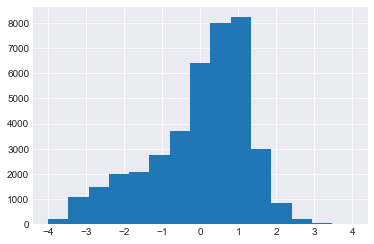

In [3]:
df['deviation'].hist(bins=15)
df['deviation'].describe()

The values -0.5 and 1.0 mark the lower and upper quartiles of the dataset, and so that is how we choose our cutoffs for trustworthiness.

Next we define convenient functions to encode our "under" or "over" parameters. Trustworthy reviews get a score of 0, while scores that are over or under the mean get a score of $\pm 1$.  

In [4]:
def under_score(x):
    if x<-0.5:
        return 1
    else:
        return 0
    
def over_score(x):
    if x>1:
        return 1
    else:
        return 0

def score(x):
    if x<-0.5:
        return -1
    elif x>1:
        return 1
    else:
        return 0

The reviews are of all different word lengths, so we convert review to a sequence of vectors of fixed length. We choose **400** words. 

In [5]:
max_words = 400
n_word_vec = len(nlp('hello').vector)

def review_to_vec_seq(review):
    vec_seq = np.array([word.vector for word in nlp(review)])
    if len(vec_seq) < max_words:
        return(np.concatenate((vec_seq, np.zeros((max_words-vec_seq.shape[0],n_word_vec)))))
    else:
        return(vec_seq[:max_words])

Additionally, we want to have a low false positive rate, so we will skew the distribution of the training data for each classifier appropriately. That is, in general we can break up the loss function as a sum over positive and negative training instances. Let $\overline \ell _p$ and $\overline \ell_n$ be the average loss on positive and negative instances respectively. Therefore we can write the total loss as

$$ \mathscr L = N_p \overline \ell_p + N_n \overline \ell_n\, , $$

where $N_p$ and $N_n$ are the number of positive and negative instances respectively. We can think of $N_p$ and $N_n$ then as weights determining how much we should penalize a high loss on positive and negative instances. Therefore, if we want to penalize misclassifying negative instances more than misclassifying positive instances (i.e. penalize false positives more than false negatives), we should have $N_n > N_p$. Note that this approach is equivalent to weighting the loss function differently for positive and negative instances.

To do so we first have to separate our training data by score. We order the training instances by the deviation, then find the border between negative, neutral, and positive instances.

In [6]:
df_train = df.iloc[:N_train].sort_values('deviation')

neg_neut_border = len(df_train[df_train['deviation'] < -0.5])
neut_pos_border = len(df_train[df_train['deviation'] <= 1])

n_neg = neg_neut_border
n_neut = neut_pos_border-neg_neut_border
n_pos = N_train - neut_pos_border

In [7]:
np.round((n_neg / N_train, n_neut/N_train, n_pos/N_train),3)

array([0.24 , 0.658, 0.102])

For the "under" classifier we use a 2:1 ratio of negatives to positives, and for the "over" classifier we use a 3:1 ratio (which we decided through experimentation). The desired target is to use 10000 instances to train each classifier. 

In [8]:
under_base = min(3333,int((n_neut+n_pos)/2), int(n_neg))
under_draws = random.sample(range(neg_neut_border),under_base+1)+random.sample(range(neg_neut_border,N_train),2*under_base)

over_base = min(2500,int((n_neut+n_neg)/3),int(n_pos))
over_draws = random.sample(range(neut_pos_border),3*over_base)+random.sample(range(neut_pos_border,N_train),over_base)

In [9]:
len(under_draws), len(over_draws)

(10000, 10000)

Next we build the training and test sets to use for the classifiers.

In [10]:
X_over = df_train.iloc[over_draws]['text'].apply(review_to_vec_seq).values
X_over = np.array([x for x in X_over])

X_under = df_train.iloc[under_draws]['text'].apply(review_to_vec_seq).values
X_under = np.array([x for x in X_under])

Y_over = df_train.iloc[over_draws]['deviation'].apply(over_score).values
Y_under = df_train.iloc[under_draws]['deviation'].apply(under_score).values
Y_train = df_train['deviation'].apply(score).values

In [11]:
df_test = df.iloc[N_train:]
X_test = df_test['text'].apply(review_to_vec_seq).values

X_test = np.array([x for x in X_test])

Y_test_over = df_test['deviation'].apply(over_score).values
Y_test_under = df_test['deviation'].apply(under_score).values
Y_test = df_test['deviation'].apply(score).values

## Build Classifiers

Each classifier consists of two convolutional layers with max pooling, one fully connected layer, and an output layer. Additionally, we introduce two droput layers to prevent overfitting. We use 20 epochs to train each classifier, as after that the loss starts to level out.

In [12]:
over_input = Input((max_words, n_word_vec))
over_conv1 = Conv1D(64, 3, padding = "same", activation='relu')(over_input)
over_pool1 = MaxPooling1D(pool_size=2)(over_conv1)
over_conv2 = Conv1D(32, 3, padding = "same", activation='relu')(over_pool1)
over_pool2 = MaxPooling1D(pool_size=2)(over_conv2)
over_flatten = Flatten()(over_pool2)
over_drop1 = Dropout(0.2)(over_flatten)
over_dense1 = Dense(150, activation ='relu')(over_drop1)
over_drop2 = Dropout(0.2)(over_dense1)
over_out = Dense(1, activation ='sigmoid')(over_drop2)

model_over = Model(inputs = over_input, outputs = over_out)
model_over.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_over.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 400, 64)           57664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 200, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 32)           6176      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3200)              0         
__________

In [13]:
model_over.fit(X_over, Y_over, epochs=20, batch_size=256)

Epoch 1/20
10000/10000 [==============================] - 99s 10ms/step - loss: 0.5635 - acc: 0.7388
Epoch 2/20
10000/10000 [==============================] - 73s 7ms/step - loss: 0.5263 - acc: 0.7500
Epoch 3/20
10000/10000 [==============================] - 76s 8ms/step - loss: 0.4993 - acc: 0.7504
Epoch 4/20
10000/10000 [==============================] - 74s 7ms/step - loss: 0.4846 - acc: 0.7564
Epoch 5/20
10000/10000 [==============================] - 76s 8ms/step - loss: 0.4439 - acc: 0.7745
Epoch 6/20
10000/10000 [==============================] - 77s 8ms/step - loss: 0.3995 - acc: 0.8033
Epoch 7/20
10000/10000 [==============================] - 78s 8ms/step - loss: 0.3647 - acc: 0.8272
Epoch 8/20
10000/10000 [==============================] - 75s 8ms/step - loss: 0.3290 - acc: 0.8537
Epoch 9/20
10000/10000 [==============================] - 75s 8ms/step - loss: 0.2754 - acc: 0.8770
Epoch 10/20
10000/10000 [==============================] - 74s 7ms/step - loss: 0.2347 - acc: 0.899

Train "under" Classifier

In [14]:
under_input = Input((max_words, n_word_vec))
under_conv1 = Conv1D(64, 3, padding = "same", activation='relu')(under_input)
under_pool1 = MaxPooling1D(pool_size=2)(under_conv1)
under_conv2 = Conv1D(32, 3, padding = "same", activation='relu')(under_pool1)
under_pool2 = MaxPooling1D(pool_size=2)(under_conv2)
under_flatten = Flatten()(under_pool2)
under_drop1 = Dropout(0.2)(under_flatten)
under_dense1 = Dense(150, activation ='relu')(under_drop1)
under_drop2 = Dropout(0.2)(under_dense1)
under_out = Dense(1, activation ='sigmoid')(under_drop2)

model_under = Model(inputs = under_input, outputs = under_out)
model_under.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_under.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 400, 300)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 400, 64)           57664     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 200, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 200, 32)           6176      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3200)              0         
__________

In [15]:
model_under.fit(X_under, Y_under, epochs=20, batch_size=256)

Epoch 1/20
10000/10000 [==============================] - 105s 11ms/step - loss: 0.5664 - acc: 0.6964
Epoch 2/20
10000/10000 [==============================] - 74s 7ms/step - loss: 0.4133 - acc: 0.8050
Epoch 3/20
10000/10000 [==============================] - 75s 7ms/step - loss: 0.3665 - acc: 0.8367
Epoch 4/20
10000/10000 [==============================] - 74s 7ms/step - loss: 0.3371 - acc: 0.8520
Epoch 5/20
10000/10000 [==============================] - 75s 7ms/step - loss: 0.2878 - acc: 0.8798
Epoch 6/20
10000/10000 [==============================] - 76s 8ms/step - loss: 0.2601 - acc: 0.8924
Epoch 7/20
10000/10000 [==============================] - 75s 7ms/step - loss: 0.2088 - acc: 0.9173
Epoch 8/20
10000/10000 [==============================] - 74s 7ms/step - loss: 0.1812 - acc: 0.9308
Epoch 9/20
10000/10000 [==============================] - 76s 8ms/step - loss: 0.1741 - acc: 0.9331
Epoch 10/20
10000/10000 [==============================] - 74s 7ms/step - loss: 0.1264 - acc: 0.95

Save models

In [16]:
model_over.save("CNN_over.h5")
model_under.save("CNN_under.h5")

## Evaluate Model

We can now evaluate the performance on the three class classification problem. If both a review is classified both as "under" and "over" we interpret it as being neutral.

In [17]:
def score_model(X_test, Y_test):
    N_test = len(X_test)
    Y_pred_over = np.reshape(np.round(model_over.predict(X_test)),(N_test,))
    Y_pred_under = np.reshape(np.round(model_under.predict(X_test)),(N_test,))

    Y_score = (Y_pred_over-Y_pred_under) - Y_test

    acc = sum(1 for y in Y_score if y==0) / N_test
    
    print("Accuracy: ", str(round(100*acc))+"%")
    
    return(Y_pred_over, Y_pred_under, acc)

In [18]:
Y_pred_over, Y_pred_under, acc = score_model(X_test,Y_test)
Y_pred = (Y_pred_over-Y_pred_under)

Accuracy:  71%


We have over 70% accuracy, which is pretty good! Additionally, we can look at the confusion matrix for this classifier.

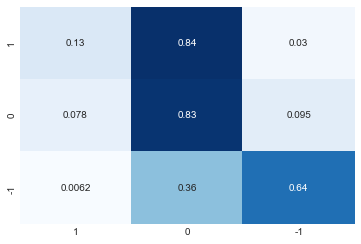

In [19]:
cmat= confusion_matrix(Y_test,Y_pred,labels=[1,0,-1])
cmat_norm = [r/sum(r) for r in cmat]
sns.heatmap(pd.DataFrame(cmat_norm,index=[1,0,-1], columns=[1,0,-1]), annot=True, cbar=False, cmap="Blues")

We see that the classifier is very conservative about predict that reviews will be over the mean, which we made by design. The recall is quite low, although the precision is high. For reviews that are under the mean, the classifier does much better. Indeed if all we care about is predicting if a review will be "too low," we have the following confusion matrix.

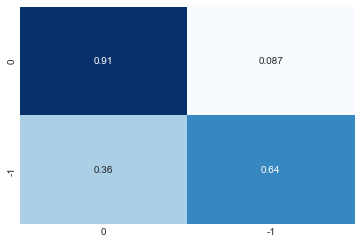

In [20]:
cmat_under = [[sum(cmat[:2,:2].flatten()), cmat[0,2]+cmat[1,2]],[cmat[2,0]+cmat[2,1], cmat[2,2]]]
cmat_under_norm = [row/sum(row) for row in cmat_under]
sns.heatmap(pd.DataFrame(cmat_under_norm,index=[0,-1], columns=[0,-1]), annot=True, cbar=False, cmap="Blues")

In [21]:
acc_under = sum(np.diagonal(cmat_under))/N_test
print("Accuracy: ", str(int(round(100*acc_under)))+"%")

Accuracy:  85%


The accuracy is 85%, and again we see by design that the precision is very high. 

Finally, we can look at a histogram of true values versus predicted values.

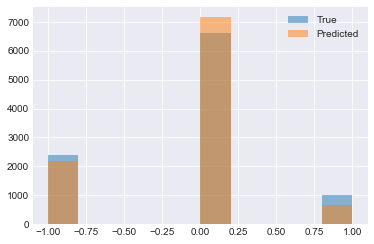

In [22]:
plt.hist(Y_test,alpha=0.5, label = "True")
plt.hist(Y_pred,alpha=0.5, label = "Predicted")
plt.legend()
plt.show()

We see we were a bit overzealous in keeping our false positive rates down, and so the classifier might do better with some further tuning. 

### Baselines

To compute a baseline for this problem, we consider the following general model for a multiclass problem. Let there be $n_1, n_2, \cdots$ instances of each class in the test set with total number of instances $n$. A random guessing model could randomly order all the instances, then take the first $n_1$ to be class $1$, the next $n_2$ to be class $2$, etc. The expected number of instances classified correctly for class $i$ is given by $n_i * n_i/n$, as we choose $n_i$ random samples, each with probability $n_i/n$ of being class $i$. 

Therefore the total expected accuracy is given by 
$$\text{acc} = \frac1 n\left({n_1^2/n + n_2^2 / n + \cdots}\right) = \frac 1{n^2} \left( n_1^2 + n_2^2 + \cdots\right)$$

We can compute this for each of our classification problems.

In [23]:
sum(sum(cmat[k])**2 for k in range(3)) / N_test**2

0.50264114

For the three class problem our 71% accuracy is over 20% better than random guessing.

In [24]:
sum(sum(cmat_under[k])**2 for k in range(2)) / sum(sum(cmat_under))**2

0.63436928

For just classifying underrated reviews the 85% accuracy is also over 20% better than random guessing.